# Exploring the UTx000 Extension EMA and Fitbit Data
(See the [GH repo](https://github.com/intelligent-environments-lab/utx000))

In [1]:
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

## Self-Report vs Measured Sleep
In this notebook we take a more in-depth look at self-report vs Fitbit-measure sleep metrics.

In [2]:
import os
import sys
sys.path.append('../')

import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

import statsmodels.api as sm

## Data Import
Here we import the morning surveys and the daily Fitbit data

### Morning Sleep Surveys

In [3]:
sr_sleep = pd.read_csv('../data/processed/beiwe-morning_ema-ux_s20.csv',index_col=0,parse_dates=True)
print(f'Length before removing NaNs:\t{len(sr_sleep)}')
for column in ['tst','sol','naw','restful']:
    sr_sleep = sr_sleep[sr_sleep[column].notna()]
    sr_sleep = sr_sleep[sr_sleep[column] > -0.5]
print(f'Length after removing NaNs:\t{len(sr_sleep)}')
sr_sleep.head()

Length before removing NaNs:	2470
Length after removing NaNs:	2422


,beiwe,content,stress,lonely,sad,energy,tst,sol,naw,restful,redcap,beacon
timestamp,,,,,,,,,,,,
2020-05-13 09:10:27,qh34m4r9,3,0.0,0.0,0.0,1.0,8.0,20.0,2.0,3.0,68,19.0
2020-05-13 09:15:49,awa8uces,0.0,2.0,1.0,1.0,1.0,2.0,10.0,3.0,1.0,28,26.0
2020-05-13 09:42:19,xxvnhauv,1,1.0,1.0,3.0,0.0,6.0,30.0,3.0,1.0,21,22.0
2020-05-13 09:43:27,rvhdl2la,1,1.0,2.0,3.0,0.0,5.3,5.0,2.0,2.0,29,NaN
2020-05-13 10:11:51,q5y11ytm,3,1.0,0.0,1.0,2.0,2.0,10.0,0.0,0.0,48,NaN


### Daily Fitbit Metrics

In [4]:
fb_sleep = pd.read_csv("../data/processed/fitbit-sleep_daily-ux_s20.csv",index_col="date",parse_dates=True,infer_datetime_format=["date","start_time","end_time"])
fb_sleep = fb_sleep[fb_sleep["main_sleep"] == True]
hrs = []
for dt in pd.to_datetime(fb_sleep["start_time"]):
    hrs.append(dt.hour)
fb_sleep["hour"] = hrs
fb_sleep = fb_sleep[~fb_sleep["hour"].isin(np.arange(10,18,1))]
fb_sleep.drop(["hour"],axis=1,inplace=True)
fb_sleep.head()

,duration_ms,efficiency,end_time,main_sleep,minutes_after_wakeup,minutes_asleep,minutes_awake,minutes_to_sleep,start_time,time_in_bed,beiwe,redcap,beacon,sol,wol
date,,,,,,,,,,,,,,,
2020-05-14,24360000,93.349754,2020-05-14T07:13:00.000,True,0,379,27,0,2020-05-14T00:27:00.000,406,hfttkth7,NaN,NaN,8.5,0.0
2020-05-15,29580000,79.513185,2020-05-15T08:06:30.000,True,8,392,101,0,2020-05-14T23:53:30.000,493,hfttkth7,NaN,NaN,0.0,32.5
2020-05-16,19740000,87.234043,2020-05-16T04:57:00.000,True,7,287,42,0,2020-05-15T23:28:00.000,329,hfttkth7,NaN,NaN,11.5,11.0
2020-05-17,26820000,90.156600,2020-05-17T09:28:30.000,True,8,403,44,0,2020-05-17T02:01:30.000,447,hfttkth7,NaN,NaN,12.5,8.5
2020-05-18,24960000,84.375000,2020-05-18T07:20:00.000,True,0,351,65,0,2020-05-18T00:24:00.000,416,hfttkth7,NaN,NaN,11.5,0.0


<div class="alert alert-block alert-warning">
    
Have to be sure to remove any sleep measured by Fitbit that is not ```main_sleep```

# Data Summary and Comparison
Since both the survey and fitbit-recorded sleep are on the same resolution, we can easily compare their overall statistics.

## Sleep Metric Overview - Fitbit and EMA
Here we look at the aggregated data across all participants for the two data modalities.

### Available Data

In [5]:
print(f'Number of sleep surveys:\t{len(sr_sleep)}')
print(f'Number of fitbit records:\t{len(fb_sleep)}')

Number of sleep surveys:	2422
Number of fitbit records:	3474


<div class="alert alert-block alert-warning">

There seem to be quite a few records to look at, however we have to see how many nightly records actually overlap. 

- The sleep surveys are indexed by the day that the participant woke up - for the most part
- Fitabase data dictionary does not have a record for ```dateOfSleep``` although they do have ```sleepDate```, however these seem to be different variables. Looking at the data, ```dateOfSleep``` seems to correspond to the date of the ```endTime``` label not the ```startTime``` label which Fitabase suggests.

Based on the points above, we just have to check the overlap between the **date of the sleep survey data** and the **date of the fitbit sleep data** per participant to see the combined records that are available.
    
</div>

In [6]:
# Pts with fitbits
fb_beiwe = fb_sleep['beiwe'].unique()
# Pts who took surveys
sr_beiwe = sr_sleep['beiwe'].unique()
print(f'Number of Fitbit Participants:\t{len(fb_beiwe)}\nNumber of Survey Participants:\t{len(sr_beiwe)}')

Number of Fitbit Participants:	53
Number of Survey Participants:	62


In [7]:
# list of pts from both
pt_list = np.intersect1d(fb_beiwe,sr_beiwe)
print(f'Length of Intersecting Participants:\t{len(pt_list)}')
print(pt_list)

Length of Intersecting Participants:	46
['15tejjtw' '1a9udoc5' '1adkek2h' '2xtqkfz1' '43b1cd5m' '4i7679py'
 '51opds1x' '5fvmg226' '6rxyg4rp' '745vq78e' '7dhu3pn7' '9jtzsuu8'
 '9xmhtq74' 'axk49ssu' 'bayw6h9b' 'drs2jy5f' 'e73a1pd5' 'eyf8oqwl'
 'gqpcflwk' 'h8aoiyhv' 'hcpu5myv' 'hxj6brwj' 'i31pt4b4' 'i4w8dx6l'
 'idbkjh8u' 'itmylz3g' 'kyj367pi' 'lkkjddam' 'mm69prai' 'o6xwrota'
 'olaxadz5' 'oxcpr7e3' 'qh34m4r9' 'rjcs3hyw' 'rkem5aou' 'rnse61g4'
 'rvhdl2la' 't4jphih6' 'tlmlq19s' 'tmexej5v' 'vpy1a985' 'vr9j5rry'
 'xdbdrk6e' 'xlw5ntd5' 'y1tvkx14' 'zdpffrox']


### EMA Submission Issues
Because EMAs could be submitted at any time, we need to take a closer look at EMAs that were submitted after midnight.

In [8]:
def fix_ema_timestamps(ema=sr_sleep,fb=fb_sleep,verbose=False):
    """
    Corrects the EMA timestamps based on nearby Fitbit sleep data
    """
    ema_with_dates = pd.DataFrame()
    for pt in ema["beiwe"].unique():
        dates = []
        ema_pt = ema[ema['beiwe'] == pt]
        try:
            fb_pt = fb[fb['beiwe'] == pt]
        except KeyError:
            continue
        for ema_dt in ema_pt.index:
            dates.append(ema_dt.date())
            if ema_dt.hour < 9:
                try:
                    fb_info = fb_pt.loc[ema_dt.date(),:]
                except KeyError:
                    fb_info = 0
                    if verbose:
                        print(f"EMA Hour:\t{ema_dt.hour}\nNo Fitbit data for this day\n")
                    #dates.append(ema_dt.date())
                if type(fb_info) != int:
                    fb_start = pd.to_datetime(fb_info["start_time"])
                    fb_end = pd.to_datetime(fb_info["end_time"])
                    if ema_dt.day == fb_start.day:
                        if ema_dt.hour < fb_start.hour:
                            if verbose:
                                print(f"EMA DT:\t{ema_dt}\nFB DT:\t{fb_start}\nSubtract an Hour\n")
                            dates[-1] -= timedelta(days=1)
                    elif ema_dt.day == fb_end.day:
                        if ema_dt.hour > fb_end.hour:
                            dow = ema_dt.strftime("%A")
                            if verbose:
                                print(f"EMA DT:\t{ema_dt}\nFB DT:\t{fb_end}\nNo Change - {dow}\n")
                    else:
                        if verbose:
                            print(f"EMA DT:\t{ema_dt}\nFB SDT:\t{fb_start}\nFB EDT:\t{fb_end}\nSomething isn\'t right here")
                        
        ema_pt["dates"] = dates
        ema_with_dates = ema_with_dates.append(ema_pt)

    return ema_with_dates

In [9]:
d = fix_ema_timestamps(verbose=True)

EMA Hour:	8
No Fitbit data for this day

EMA Hour:	8
No Fitbit data for this day

EMA Hour:	7
No Fitbit data for this day

EMA Hour:	6
No Fitbit data for this day

EMA Hour:	7
No Fitbit data for this day

EMA Hour:	1
No Fitbit data for this day

EMA Hour:	0
No Fitbit data for this day

EMA Hour:	1
No Fitbit data for this day

EMA Hour:	8
No Fitbit data for this day

EMA Hour:	0
No Fitbit data for this day

EMA Hour:	0
No Fitbit data for this day

EMA Hour:	0
No Fitbit data for this day

EMA Hour:	0
No Fitbit data for this day

EMA Hour:	1
No Fitbit data for this day

EMA Hour:	1
No Fitbit data for this day

EMA Hour:	0
No Fitbit data for this day

EMA Hour:	8
No Fitbit data for this day

EMA Hour:	8
No Fitbit data for this day

EMA Hour:	0
No Fitbit data for this day

EMA Hour:	6
No Fitbit data for this day

EMA Hour:	8
No Fitbit data for this day

EMA Hour:	6
No Fitbit data for this day

EMA Hour:	4
No Fitbit data for this day

EMA Hour:	8
No Fitbit data for this day

EMA Hour:	0
No F

In [10]:
# creating date column
dates = []
for d in sr_sleep.index:
    if d.hour >= 0 and d.hour + d.minute/60 < 8.5:
        dates.append(d.date() - timedelta(days=1))
    else:
        dates.append(d.date())
sr_sleep['date'] = pd.to_datetime(dates)

<div class="alert alert-block alert-warning">

Participants who filled out their sleep survey prior to 3:00 are _most likely_ responding to the previous day's sleep. This is taken into account in the previous cell.

### Available Participants

First, let's check that we have the same participants for both modalities:

## Combining Sleep Data
Now we can loop through the participants, combining days of self-report and measured sleep metrics when both records exist. 

In [11]:
combined_sleep = pd.DataFrame() # dataframe to append to
for pt in pt_list:
    sr_sleep_beiwe = sr_sleep[sr_sleep['beiwe'] == pt]
    fb_sleep_beiwe = fb_sleep[fb_sleep['beiwe'] == pt]
    temp = pd.merge(left=sr_sleep_beiwe,right=fb_sleep_beiwe,left_on='date',right_index=True,how='inner')
    temp.drop(["beiwe_x","beiwe_y"],axis=1,inplace=True)
    temp["beiwe"] = pt
    combined_sleep = combined_sleep.append(temp)
    
# renaming and dropping for easier use



Now we can see how many nights of data we have from both modalities in addition to if we lost any participants due to lack of overlap.

In [12]:
combined_sleep = pd.read_csv("../data/processed/beiwe_fitbit-sleep_summary-ux_s20.csv",index_col=0)
combined_sleep.head()

,start_date,end_date,deep_count,deep_minutes,light_count,light_minutes,rem_count,rem_minutes,wake_count,wake_minutes,beiwe,efficiency,end_time,start_time,redcap,beacon,nrem_count,nrem_minutes,rem2nrem,tst_fb,rem_percent,nrem_percent,waso,sol_fb,wol_fb,tst_ema,sol_ema,naw_ema,restful_ema
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-05-14,2020-05-14 00:00:00,2020-05-14 00:00:00,3,73,45,331,8,122,47,107,15tejjtw,83.096367,2020-05-14 11:39:30,2020-05-14 01:06:00,45.0,NaN,48,404,0.301980,8.766667,0.231939,0.768061,84.5,13.0,9.5,9.0,30.0,5.0,2.0
2020-05-16,2020-05-16 00:00:00,2020-05-16 00:00:00,2,65,31,282,6,49,35,65,15tejjtw,85.900217,2020-05-16 10:00:30,2020-05-16 02:19:00,45.0,NaN,33,347,0.141210,6.600000,0.123737,0.876263,57.5,4.0,3.5,9.0,15.0,2.0,2.0
2020-05-17,2020-05-17 00:00:00,2020-05-17 00:00:00,4,123,31,273,15,135,35,70,15tejjtw,88.352745,2020-05-17 10:28:00,2020-05-17 00:27:00,45.0,NaN,35,396,0.340909,8.850000,0.254237,0.745763,53.0,13.0,4.0,9.0,30.0,1.0,2.0
2020-05-18,2020-05-18 00:00:00,2020-05-18 00:00:00,5,80,33,299,5,99,28,84,15tejjtw,85.053381,2020-05-18 10:59:30,2020-05-18 01:37:00,45.0,NaN,38,379,0.261214,7.966667,0.207113,0.792887,71.0,13.0,0.0,9.0,25.0,2.0,1.0
2020-05-22,2020-05-21 00:00:00,2020-05-22 00:00:00,6,102,30,265,17,132,35,69,15tejjtw,87.852113,2020-05-22 09:27:30,2020-05-21 23:59:30,45.0,NaN,36,367,0.359673,8.316667,0.264529,0.735471,56.0,0.0,13.0,9.0,20.0,2.0,2.0


In [13]:
print(f'Number of overlapping nights: {len(combined_sleep)}')
n = len(combined_sleep['beiwe'].unique())
print(f'\tFrom {n} participants')

Number of overlapping nights: 1060
	From 46 participants


# Sleep Metric Comparison
The following cells look at similar sleep metrics measured across platforms.

In [14]:
def plot_tst_comparision_histograms(df=combined_sleep,sleep_metric="tst",save=False,figure_note="all"):
    """
    
    """
    fig, axes = plt.subplots(1,3,figsize=(18,6),sharey='row')
    for vals, b, color, title, ax in zip([df[f'{sleep_metric}_ema'],df[f'{sleep_metric}_fb'],df[f'{sleep_metric}_ema']-df[f'{sleep_metric}_fb']],
                                        [np.arange(0,15,1),np.arange(0,15,1),np.arange(-8,9,1)],
                                        ["cornflowerblue","firebrick","seagreen"],["Self-Report","Fitbit-Measured","Difference (Self-Report - Fitbit-Measured)"],axes.flat):
        ax.hist(vals,bins=b,density=True,rwidth=0.9,color=color,edgecolor='black')
        ax.set_title(title)
        for loc in ["top","right"]:
            ax.spines[loc].set_visible(False)
            
        ax.set_xlabel("Hours")

    plt.subplots_adjust(wspace=0)
    if save:
        plt.savefig(f"../reports/figures/ema_vs_fitbit/beiwe-fitbit-tst-tst-histogram_comparison_{figure_note}-ux_s20.pdf")
    plt.show()
    plt.close()

## Total Sleep Time
Total sleep time (TST) in hours

### Comparing All Available Data

Renaming columns for easier use

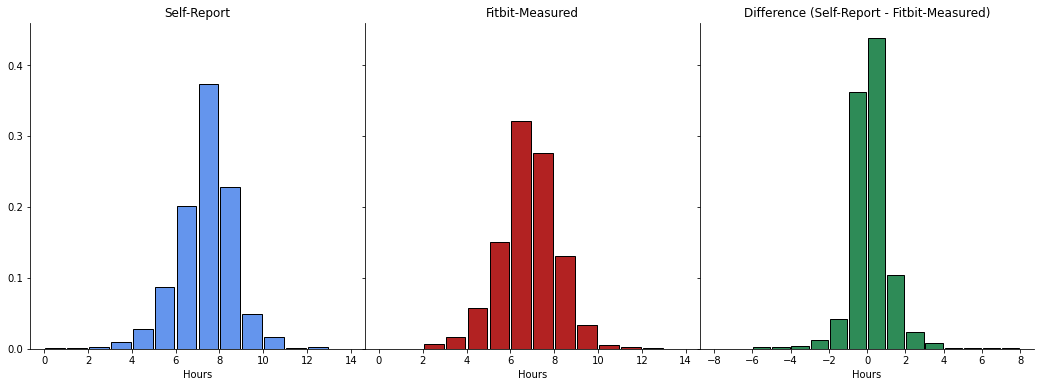

In [15]:
plot_tst_comparision_histograms()

<div class="alert alert-block alert-info">
    
**TST Comparison - All Data**
    
Results are interesting particularly when analyzing the difference histrogram (green). 

When looking at the differences, the mean value is shifted left meaning one of two things:
1. On average, Fitbit **over-estimates** the TST
2. On average, participants **under-estimate** their TST
    
Zooming out, the differences show values of up to 7 hours. These make little sense and should be further investigated.

### TST Outliers
In the following cells we look at the nights when participants reported dramatically different TST.

In [16]:
def check_sleep_outliers(df=combined_sleep,sleep_metric="tst",threshold=3):
    """
    Returns a dataframe of the outlying data from the given dataframte based on the sleep metric and the threshold
    """
    # creating a tst_difference column and checking the nights with abs(tst) greater than 3 hours
    df["difference"] = abs(df[f"{sleep_metric}_fb"] - df[f"{sleep_metric}_ema"])
    df_outlier = df[df["difference"] >= threshold]
    return df_outlier

In [17]:
check_sleep_outliers(threshold=4)

,start_date,end_date,deep_count,deep_minutes,light_count,light_minutes,rem_count,rem_minutes,wake_count,wake_minutes,beiwe,efficiency,end_time,start_time,redcap,beacon,nrem_count,nrem_minutes,rem2nrem,tst_fb,rem_percent,nrem_percent,waso,sol_fb,wol_fb,tst_ema,sol_ema,naw_ema,restful_ema,difference
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-07-04,2020-07-04 00:00:00,2020-07-04 00:00:00,3,104,46,470,12,97,48,144,1adkek2h,82.331288,2020-07-04 18:46:30,2020-07-04 05:11:00,87.0,NaN,49,574,0.168990,11.183333,0.144560,0.855440,104.0,4.0,36.0,6.0,40.0,0.0,2.0,5.183333
2020-05-27,2020-05-26 00:00:00,2020-05-27 00:00:00,2,119,42,394,12,117,40,64,5fvmg226,90.778098,2020-05-27 08:18:30,2020-05-26 20:44:30,38.0,23.0,44,513,0.228070,10.500000,0.185714,0.814286,59.0,5.0,0.0,6.5,10.0,1.0,2.0,4.000000
2020-05-28,2020-05-27 00:00:00,2020-05-28 00:00:00,4,128,27,266,14,133,30,52,745vq78e,91.018998,2020-05-28 07:35:30,2020-05-27 21:56:00,55.0,5.0,31,394,0.337563,8.783333,0.252372,0.747628,47.5,0.0,4.5,3.0,0.0,0.0,2.0,5.783333
2020-06-04,2020-06-03 00:00:00,2020-06-04 00:00:00,5,113,35,323,15,152,38,58,745vq78e,91.021672,2020-06-04 07:41:30,2020-06-03 20:55:30,55.0,5.0,40,436,0.348624,9.800000,0.258503,0.741497,47.5,0.0,10.5,5.0,0.0,1.0,2.0,4.800000
2020-08-16,2020-08-15 00:00:00,2020-08-16 00:00:00,2,54,21,201,7,62,25,55,745vq78e,85.215054,2020-08-16 04:55:30,2020-08-15 22:43:30,55.0,5.0,23,255,0.243137,5.283333,0.195584,0.804416,36.0,0.0,19.0,11.7,0.0,0.0,3.0,6.416667
2020-07-15,2020-07-15 00:00:00,2020-07-15 00:00:00,3,67,37,376,7,99,32,145,7dhu3pn7,78.893741,2020-07-15 11:43:30,2020-07-15 00:16:30,64.0,NaN,40,443,0.223476,9.033333,0.182657,0.817343,144.5,0.5,0.0,5.0,15.0,0.0,1.0,4.033333
2020-06-12,2020-06-12 00:00:00,2020-06-12 00:00:00,2,39,26,177,4,54,27,52,lkkjddam,83.850932,2020-06-12 11:09:00,2020-06-12 05:47:00,12.0,21.0,28,216,0.250000,4.500000,0.200000,0.800000,41.5,10.5,0.0,8.5,10.0,3.0,2.0,4.000000
2020-06-13,2020-06-13 00:00:00,2020-06-13 00:00:00,1,32,22,241,7,56,24,54,vpy1a985,85.900783,2020-06-13 13:34:30,2020-06-13 07:11:00,50.0,NaN,23,273,0.205128,5.483333,0.170213,0.829787,54.0,0.0,0.0,0.0,0.0,0.0,0.0,5.483333
2020-08-17,2020-08-17 00:00:00,2020-08-17 00:00:00,1,32,16,94,5,37,19,26,xdbdrk6e,86.243386,2020-08-17 07:12:30,2020-08-17 04:03:30,23.0,24.0,17,126,0.293651,2.716667,0.226994,0.773006,25.5,0.5,0.0,8.0,60.0,3.0,1.0,5.283333


<div class="alert alert-block alert-danger">
What is the best way to deal with TST differences that are so largely negative and/or positive?

### Removing Outliers

We try two methods to remove values of TST that don't agree. We have to start by creating a new variable that is the absolute value of the difference between the two measurements. Then we can do outlier detection on that distribution. 
1. Z-Score: We calculate the z-score of the differences and only use TST values where the z-score is less than 2.5 for the difference
2. IQR: We calculate the IQR for the difference in TST between modalities and remove values that are $1.5*IQR$ greater than the 75% percentile and $1.5*IQR$ less than the 25% percentile.

In [18]:
combined_sleep['TST_Difference'] = combined_sleep['tst_ema'] - combined_sleep['tst_fb']
combined_sleep['Difference_Z'] = (combined_sleep['TST_Difference'] - np.mean(combined_sleep['TST_Difference'])) / np.std(combined_sleep['TST_Difference'])
reduced_sleep_z = combined_sleep[abs(combined_sleep['Difference_Z']) < 2.5]

iqr = np.percentile(combined_sleep['TST_Difference'],75) - np.percentile(combined_sleep['TST_Difference'],25)
reduced_sleep_iqr = combined_sleep[(combined_sleep['TST_Difference'] < np.percentile(combined_sleep['TST_Difference'],75) + 1.5*iqr) & (combined_sleep['TST_Difference'] > np.percentile(combined_sleep['TST_Difference'],25) - 1.5*iqr)]

print(f'N for Complete Dataset:\t\t\t{len(combined_sleep)}')
print(f'N for Reduced Dataset (z-score):\t{len(reduced_sleep_z)}')
print(f'N for Reduced Dataset (iqr):\t\t{len(reduced_sleep_iqr)}')

N for Complete Dataset:			1060
N for Reduced Dataset (z-score):	1026
N for Reduced Dataset (iqr):		985


In [19]:
slope_models = []
full_models = []
dataset_labels = ['Complete','Reduced by Z-Score','Reduced by 1.5xIQR']
for df, dataset in zip([combined_sleep,reduced_sleep_z,reduced_sleep_iqr],dataset_labels):
    print(f'OLS for {dataset} Dataset')
    x = df['tst_fb'].values
    y = df['tst_ema'].values
    # OLS - intercept at origin
    slope_model = sm.OLS(y,x).fit()
    print("\tSlope Model")
    print(f"\t\tParams:\t{slope_model.params}\n\t\tR^2:\t{slope_model.rsquared}")
    slope_models.append(slope_model)
    # OLS - intercept included
    full_model = sm.OLS(y,sm.add_constant(x)).fit()
    print("\tFull Model")
    print(f"\t\tParams:\t{full_model.params}\n\t\tR^2:\t{full_model.rsquared}")
    full_models.append(full_model)

OLS for Complete Dataset
	Slope Model
		Params:	[1.00969489]
		R^2:	0.9791563434520723
	Full Model
		Params:	[2.27835099 0.68795682]
		R^2:	0.48156199358147267
OLS for Reduced by Z-Score Dataset
	Slope Model
		Params:	[1.01477318]
		R^2:	0.9889076392816906
	Full Model
		Params:	[1.56530307 0.7936278 ]
		R^2:	0.676329825691699
OLS for Reduced by 1.5xIQR Dataset
	Slope Model
		Params:	[1.01353074]
		R^2:	0.9921316146108191
	Full Model
		Params:	[1.1788659  0.84713451]
		R^2:	0.7540777461212086


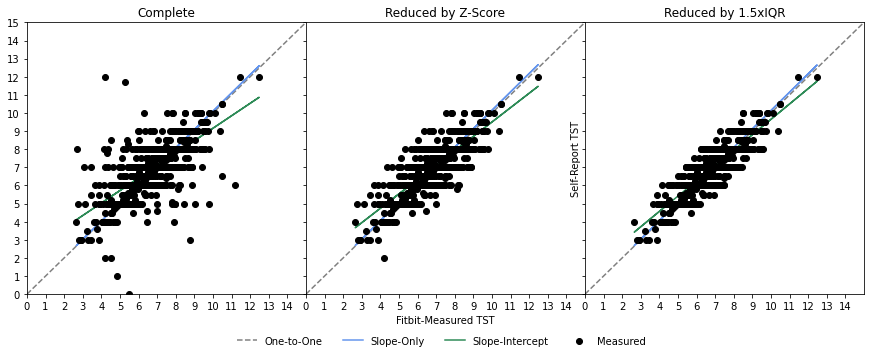

In [20]:
fig, axes = plt.subplots(1,3,figsize=(15,5),sharey='row')
dfs = [combined_sleep,reduced_sleep_z,reduced_sleep_iqr]
for i in range(3):
    ax = axes[i]
    df = dfs[i]
    # data
    ax.scatter(df['tst_fb'],df['tst_ema'],color='black',zorder=10,label='Measured')
    # one-to-one
    ax.plot([0,15],[0,15],color='gray',linestyle='dashed',zorder=1,label='One-to-One')
    # slope
    ax.plot(df['tst_fb'].values,slope_models[i].fittedvalues,color='cornflowerblue',label='Slope-Only')
    # full
    ax.plot(df['tst_fb'].values,full_models[i].fittedvalues,color='seagreen',label='Slope-Intercept')

    ax.set_xlim([0,15])
    ax.set_ylim([0,15])
    ax.set_xticks(np.arange(0,15,1))
    ax.set_yticks(np.arange(0,16,1))
    ax.set_title(dataset_labels[i])
    if i == 1:
        ax.set_xlabel('Fitbit-Measured TST')
    if i == 2:
        ax.legend(bbox_to_anchor=(0.25,-0.12),ncol=4,frameon=False)

ax.set_ylabel('Self-Report TST')
plt.subplots_adjust(wspace=0,hspace=0.15)
plt.show()
plt.close()

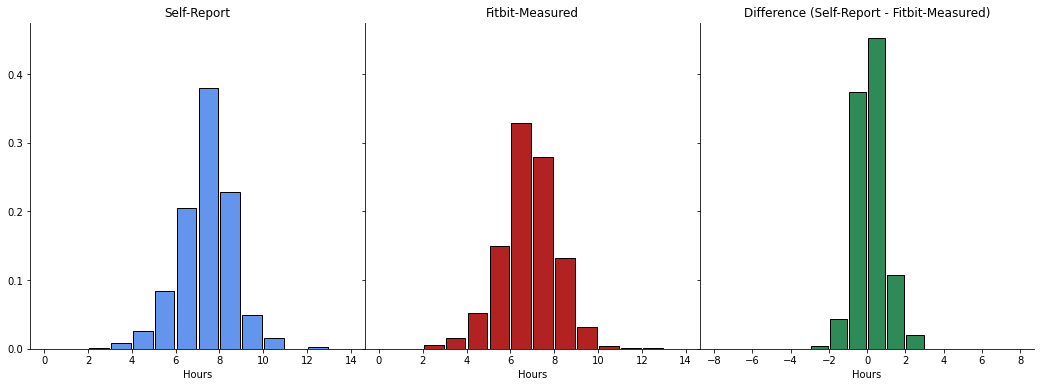

In [21]:
plot_tst_comparision_histograms(reduced_sleep_z)

### Participant Comparison Across Platforms
Now we look at individual participants and how they compared across the different modalities. With these figures it is important to highlight the individuals if possible. Some ideas include:
- Scatter with color for participants
- m-by-n figure that includes all participants with dots colored and line of best fit included where the other dots are monocolor (I like this one)

In [22]:
sorted_combined_sleep = pd.DataFrame()
for pt in combined_sleep["redcap"].unique():
    temp = combined_sleep[combined_sleep["redcap"] == pt]
    temp["n"] = len(temp)
    sorted_combined_sleep = sorted_combined_sleep.append(temp)
    
sorted_combined_sleep.sort_values(["n"],ascending=True,inplace=True)

In [108]:
from sklearn.metrics import r2_score

In [117]:
def plot_sleep_metric_vs_all(df=combined_sleep,var="tst",by_var="redcap",save=False,figure_note=""):
    """
    Plots a sleep metric for each participant over the aggregate scatter
    """
    r = 6
    c = 8
    fig, axes = plt.subplots(r,c,figsize=(c*2,r*2),sharex='col',sharey='row')
    for pt, ax in zip(df[by_var].unique(),axes.flat):
        pt_df = df[df[by_var] == pt]
        nonpt_df = df[df[by_var] != pt]
        ax.scatter(nonpt_df['tst_fb'],nonpt_df['tst_ema'],s=15,color='lightgray',zorder=1)
        ax.scatter(pt_df['tst_fb'],pt_df['tst_ema'],s=15,color='navy',zorder=2)
        ax.set_xlim([0,15])
        ax.set_ylim([0,15])
        if len(pt_df['tst_fb']) > 2:
            m, b = np.polyfit(pt_df['tst_fb'],pt_df['tst_ema'],1)
            pred = pt_df['tst_fb']*m + b
            r2 = r2_score(pt_df['tst_ema'],pred)
            ax.set_title(f"r$^2$ = {round(r2,3)}",y=0.85,pad=0)
        #ax.text(0.5,1,f"r$^2$ = {round(r2,3)}",transform=ax.transAxes,ha="center")
        #ax.set_title(str(pt)[:-2],y=0.87,pad=0)
        ax.axis('off')
        
    if r*c > len(df[by_var].unique()):
        for i in range(len(df[by_var].unique()),r*c,1):
            axes.flat[i].axis("off")

    # Hard-code annotating
    axes[r-1,0].axis('on')
    axes[r-1,0].set_xticks([0,5,10,15])
    plt.setp(axes[r-1,0].get_xticklabels(), ha="center", rotation=0, fontsize=14)
    axes[r-1,0].set_yticks([0,5,10,15])
    plt.setp(axes[r-1,0].get_yticklabels(), ha="right", rotation=0, fontsize=14)
    for loc in ["top","right"]:
        axes[r-1,0].spines[loc].set_visible(False)
    axes[2,0].text(-3.5,7.5,'Self-Report TST (hours)',rotation=90,ha='center',va='center',fontsize=18)
    axes[r-1,3].text(7.5,-3.5,'Fitbit-Measured TST (hours)',ha='center',va='top',fontsize=18)
    plt.subplots_adjust(wspace=0,hspace=0)
    plt.axis('off')
    if save:
        plt.savefig(f"../../papers/5eea5276044b790001ee5687/figures/fitbit-beiwe-{var}-{var}-comprehensive-scatter.pdf",bbox_inches="tight")
    plt.show()
    plt.close()

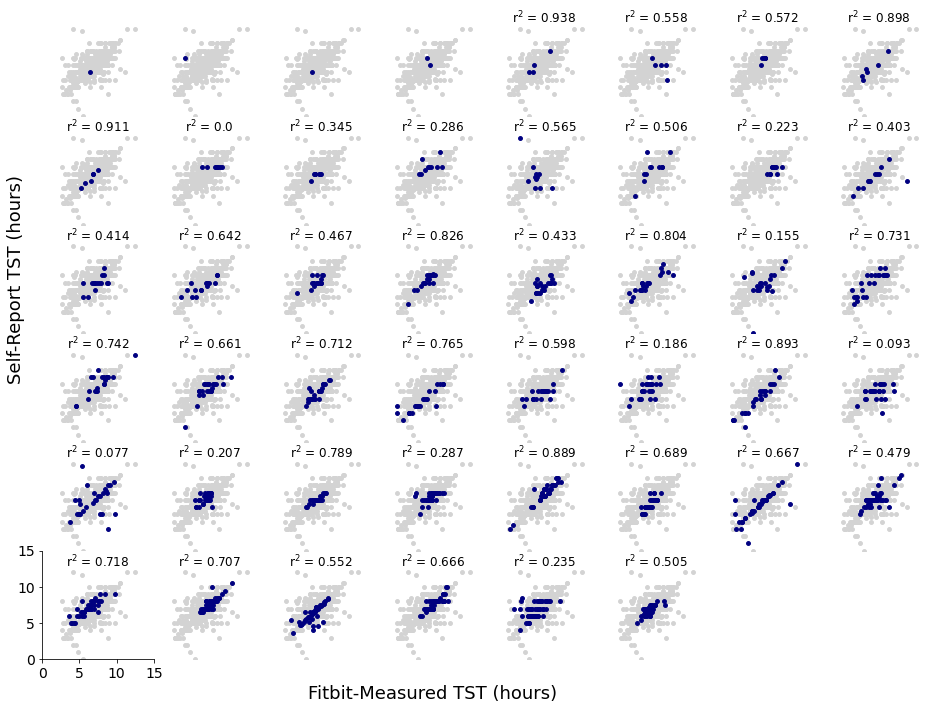

In [118]:
plot_sleep_metric_vs_all(df=sorted_combined_sleep,save=True)

In [27]:
def plot_bland_altman_with_margins(df, baseline, alternate, by_var='redcap', save=False):
    '''
    Plots a difference plot for given vars
    
    Inputs:
    - df: dataframe with columns corresponding to the baseline and alternate measurements
    - baseline: string specifying baseline var
    - alternate: string specifying alternate var
    - by_var: string specifying how to color points
    
    Returns axes of the plot
    '''
    df['mean'] = (df[alternate] + df[baseline])/2
    df['delta'] = df[alternate] - df[baseline]

    g = sns.JointGrid(data=df, x="mean", y="delta",height=8)
    g.plot_joint(sns.scatterplot,color='black',s=30)
    g.plot_marginals(sns.kdeplot,color="black",shade=True)
    #g = sns.jointplot(data=df, x='mean', y='delta', color='black', s=30, alpha=1, kind="kde",zorder=10)

    # Mean and CI lines
    u = df['delta'].mean()
    ax = g.ax_joint
    ax.axhline(u, color='black', linewidth=0.75)
    ax.text(11,u,f'mean: {round(u,2)}',va='bottom',ha='left', fontsize=12)
    
    std = df['delta'].std()
    ax.axhline(u+1.96*std, color='black', linewidth=0.75, linestyle='dashed')
    ax.text(11,u+1.96*std,f'95% CI: {round(u+1.96*std,2)}',va='bottom',ha='left', fontsize=12)
    ax.axhline(u-1.96*std, color='black', linewidth=0.75, linestyle='dashed')
    ax.text(11,u-1.96*std,f'95% CI: {round(u-1.96*std,2)}',va='bottom',ha='left', fontsize=12)
    
    # Labelling
    ax.set_xlabel('Mean TST (hours)',fontsize=16)
    ax.set_ylabel('Self-Reported TST - Fitbit TST (hours)',fontsize=16)
    ax.set_xlim([2,14])
    plt.setp(ax.get_xticklabels(), ha="center", rotation=0, fontsize=12)
    ax.set_ylim([-8,8])
    plt.setp(ax.get_xticklabels(), ha="right", rotation=0, fontsize=12)

    if save:
        plt.savefig(f"../../papers/5eea5276044b790001ee5687/figures/fitbit-beiwe-tst-tst-bland_altman-ux_s20.pdf",bbox_to_anchor='tight')

    for loc in ['right','top']:
        ax.spines[loc].set_visible(False)
        
    plt.show()
    plt.close()

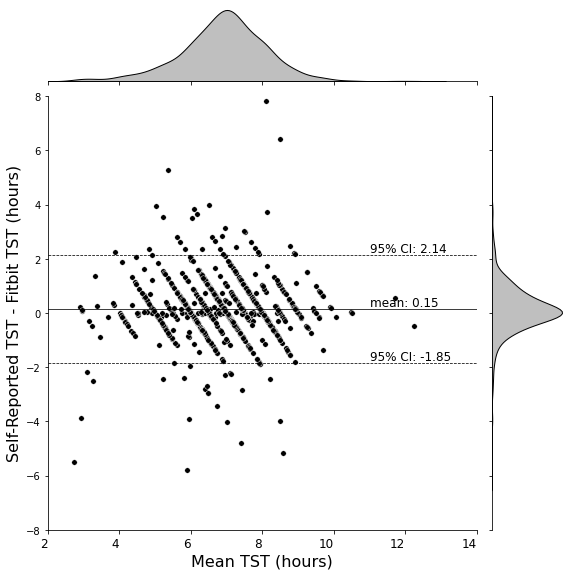

In [28]:
plot_bland_altman_with_margins(sorted_combined_sleep, 'tst_fb', 'tst_ema', save=True)

## Awakenings
While we can't compare awakenings directly across platforms, we can compare the number of awakenings reported through EMAs to Fitbit measured metrics like:
* ```wake_minutes```
* ```wake_count```
* ```efficiency```
* ```tst```

In [52]:
def compare_naw(df, fitbit_features=["wake_minutes","wake_count","efficiency","tst_fb"]):
    """scaters variables and NAW"""
    fig, axes = plt.subplots(1,len(fitbit_features),figsize=(16,4),sharey=True)
    axes[0].set_ylabel("NAW")
    for var, ax in zip(fitbit_features,axes.flat):
        ax.scatter(df[var],df["naw_ema"],color="cornflowerblue",edgecolor="black")
        for loc in ["top","right"]:
            ax.spines[loc].set_visible(False)
        ax.set_xlabel(var.replace("_"," ").title())
        
    plt.show()
    plt.close()

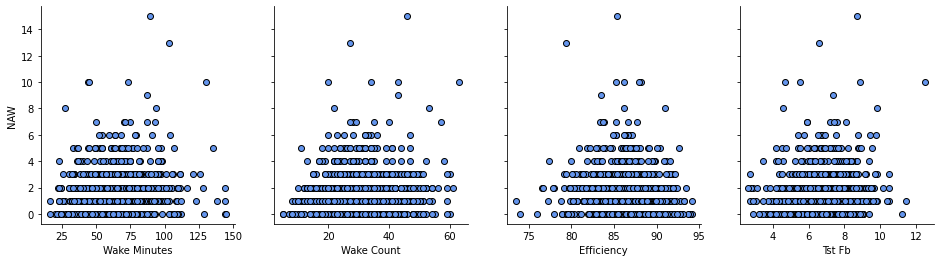

In [53]:
compare_naw(combined_sleep)

We can consider the more extreme cases when NAW > 4

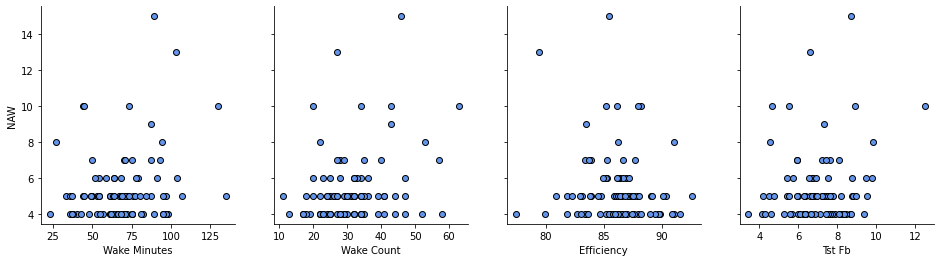

In [57]:
compare_naw(combined_sleep[combined_sleep["naw_ema"] >= 4])

<div class="alert alert-block alert-danger">

NAW does not seem to relate to any of the _likely_ Fitbit-measured sleep metrics.

### SOL
Fitbit only measures SOL if the user actively tells the device that they are settling down to go to sleep. Otherwise, the device won't accurately back out this metric, but we do have measurements of this metric to a certain degree so it would be interesting to see if there is a relationship.

In [73]:
def compare_sol(df, fb_threshold=5):
    """compares sol measured by Fitbit and EMA"""
    df_to_plot = df[df["sol_fb"] > fb_threshold]
    fig, ax = plt.subplots(figsize=(4,4))
    ax.scatter(df_to_plot["sol_fb"],df_to_plot["sol_ema"],color="cornflowerblue",edgecolor="black")
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)
    ax.set_xlabel("Fitbit",fontsize=12)
    ax.set_xlim([0,150])
    ax.set_ylabel("EMA",fontsize=12)
    ax.set_ylim([0,150])
    plt.show()
    plt.close()

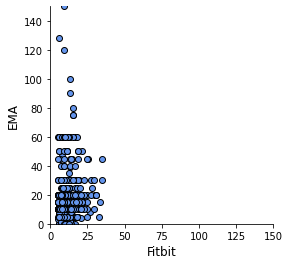

In [74]:
compare_sol(combined_sleep)

<div class="alert alert-block alert-danger">

Fitbit does not provide _accurate_ measurements of SOL so we cannot compare apples to apples - the relationship almost looks inverse.

### Restful
The ```restful``` metric that participants answer has no direct comparison to a quantitative metric, but there are many aspects of Fitbit-measured sleep that, if poor, could equate to a bad restfulness score:
* SE
* REM:nREM
* WASO

#### Binary Restful Score
We start by grouping restfulness into a "negative" and "positive" bin.

In [76]:
combined_sleep["restful_binary"] = [0 if score < 2 else 1 for score in combined_sleep["restful_ema"]]

#### Comparison

In [106]:
def compare_restful(df,fitbit_features=["rem2nrem","efficiency","waso"]):
    """compare Fitbit metrics to restfulness scores"""
    fig, axes = plt.subplots(1,len(fitbit_features),figsize=(4*len(fitbit_features),4))
    for ft, ax in zip(fitbit_features,axes.flat):
        df_to_plot = df.copy()
        df_to_plot["feature"] = ft
        sns.violinplot(x="feature",y=ft,hue="restful_binary",palette=["firebrick","seagreen"],data=df_to_plot,inner="quartile",split=True,ax=ax)
        ax.set_xlabel("")
        ax.set_ylabel(ft.title(),fontsize=14)
        ax.set_xticklabels("")
        for loc in ["top","right","bottom"]:
            ax.spines[loc].set_visible(False)
        ax.get_legend().remove()
    plt.show()
    plt.close()

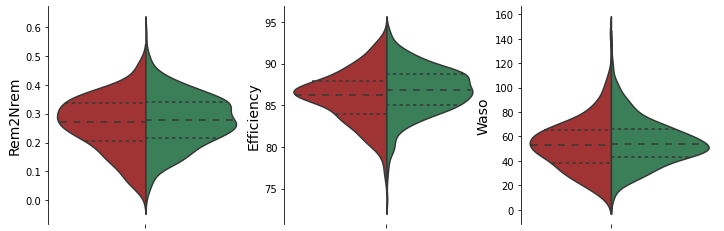

In [107]:
compare_restful(combined_sleep)

# Filtered Dataset Analysis
These next cells take a closer look at the sleep metrics from Fitbit and the EMAs for the filtered datasets rather than any night that we have data from both.

In [35]:
ff_sleep = pd.read_csv('../data/processed/fitbit_beiwe_beacon-sleep_summary-ux_s20.csv',
                      index_col=0,parse_dates=True,infer_datetime_format=True)
ff_sleep.columns

FileNotFoundError: [Errno 2] No such file or directory: '../data/processed/fitbit_beiwe_beacon-sleep_summary-ux_s20.csv'

## Aggregate Comparison
We want to see how sleep metrics vary in bulk.

### Bland Altman Difference Plot
See [here](https://www.statsmodels.org/devel/generated/statsmodels.graphics.agreement.mean_diff_plot.html) for some more information.

In [37]:
def plot_bland_altman(df, baseline, alternate, by_var='Beacon', save=False):
    '''
    Plots a difference plot for given vars
    
    Inputs:
    - df: dataframe with columns corresponding to the baseline and alternate measurements
    - baseline: string specifying baseline var
    - alternate: string specifying alternate var
    - by_var: string specifying how to color points
    
    Returns axes of the plot
    '''
    df['mean'] = (df[alternate] + df[baseline])/2
    df['delta'] = df[alternate] - df[baseline]

    fig, ax = plt.subplots(figsize=(12,6))
    sns.scatterplot(data=df, x='mean', y='delta', hue='beacon', palette='coolwarm',
                    legend=None, s=80, alpha=0.8, zorder=10)

    # Mean and CI lines
    u = ff_sleep['delta'].mean()
    ax.axhline(u, color='black', linewidth=0.75)
    ax.text(11,u,f'mean: {round(u,2)}',va='bottom',ha='left')
    
    std = ff_sleep['delta'].std()
    ax.axhline(u+1.96*std, color='black', linewidth=0.75, linestyle='dashed')
    ax.text(11,u+1.96*std,f'95% CI: {round(u+1.96*std,2)}',va='bottom',ha='left')
    ax.axhline(u-1.96*std, color='black', linewidth=0.75, linestyle='dashed')
    ax.text(11,u-1.96*std,f'95% CI: {round(u-1.96*std,2)}',va='bottom',ha='left')
    
    # Labelling
    ax.set_xlabel('Mean TST (hours)')
    ax.set_ylabel('Self-Reported TST - Fitbit TST (hours)')
    ax.set_xlim([2,12])
    ax.set_ylim([-5,8])

    if save:
        plt.savefig('../reports/figures/fitbit-beiwe-tst-tst-bland_altman-ux_s20.pdf',bbox_to_anchor='tight')
    plt.show()
    plt.close()

    for loc in ['right','top']:
        ax.spines[loc].set_visible(False)
        
    return ax

Creating plot

In [38]:
ff_sleep['durationHours'] = ff_sleep['duration_ms']/3600000
ax = plot_bland_altman(ff_sleep, 'durationHours', 'tst')

NameError: name 'ff_sleep' is not defined

## Participant Comparison
We want to show how the participant sleep metric measurements vary across devices

### Scatter Plot - Participant versus the Study
Similar to the scatter plots shown above, but with a different dataset. 

In [39]:
def scatter_tst_comparison(df, by_var='beacon', save=False, save_dir='../reports/figures/'):
    '''
    Creates a scatter plot with participant level data over aggregate data
    
    Inputs:
    - df: dataframe with Fitbit and EMA sleep metrics
    - by_var: variable to separate by
    
    Returns void
    '''
    df_to_plot = pd.DataFrame()
    for pt in df[by_var].unique():
        df_pt = df[df[by_var] == pt]
        df_pt['count'] = len(df_pt)
        df_to_plot = df_to_plot.append(df_pt)
        
    df_to_plot.sort_values('count',inplace=True)
    
    fig, ax = plt.subplots(3,6,figsize=(14,7),sharex='col',sharey='row')
    i = 0
    rows = [0,0,0,0,0,0,1,1,1,1,1,1,2,2,2,2,2,2]
    cols = [0,1,2,3,4,5]*3
    for pt, r, c in zip(df_to_plot[by_var].unique(),rows,cols):
        pt_df = df_to_plot[df_to_plot[by_var] == pt]
        nonpt_df = df_to_plot[df_to_plot[by_var] != pt]
        ax[r,c].scatter(nonpt_df['duration_ms']/3600000,nonpt_df['tst'],s=15,color='lightgray',zorder=1)
        ax[r,c].scatter(pt_df['duration_ms']/3600000,pt_df['tst'],s=15,color='navy',zorder=2)
        ax[r,c].set_xlim([0,15])
        ax[r,c].set_ylim([0,15])
        ax[r,c].set_title(pt)
        if r == max(rows) and c == min(cols):
            ax[r,c].set_xticks([0,5,10,15])
            ax[r,c].set_yticks([0,5,10,15])
            for loc in ['right','top']:
                ax[r,c].spines[loc].set_visible(False)
        else:
            ax[r,c].axis('off')

        i+=1
    ax[1,0].text(-2.5,7.5,'Self-Report Sleep Time',rotation=90,ha='center',va='center')
    ax[2,3].text(0,-2.5,'Fitbit-Measured Sleep Time',ha='center',va='top')
    plt.subplots_adjust(wspace=0,hspace=0)
    plt.axis('off')
    if save:
        plt.savefig(f'{save_dir}fitbit-beiwe-tst-tst-scatter-ux_s20.pdf',bbox_to_anchor='tight')
        
    plt.show()
    plt.close()

Now creating the scatterplot

In [40]:
scatter_tst_comparison(ff_sleep)

NameError: name 'ff_sleep' is not defined